In [1]:
import boto3
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

my_session = boto3.session.Session()
my_region = my_session.region_name

# Create a Rekognition client
rekognition = boto3.client("rekognition",
                           region_name=my_region)

# Specify the video source
bucket_name = "rekognition-video-console-demo-iad-575785594424-1688320007"
s3_key = "rekon-video/numbers_10_fps_h264.mp4"
video_source = {
    "S3Object": {
        "Bucket": bucket_name,
        "Name": s3_key
    }
}

#### Start text detection
response = rekognition.start_text_detection(
    Video=video_source,
)

# Get the job id
job_id = response["JobId"]
print(job_id)

# Poll for text detection results
import time
while True:
    response = rekognition.get_text_detection(JobId=job_id)
    status = response["JobStatus"]
    if status == "IN_PROGRESS":
        print("Text detection is in progress...")
        time.sleep(5) # Wait for a while and then check again
    elif status == "SUCCEEDED":
        print("Text detection succeeded!")
        break # Exit the loop
    elif status == "FAILED":
        print("Text detection failed!")
        break # Exit the loop
    else:
        print("Unknown status!")
        break # Exit the loop
        
response = rekognition.get_text_detection(JobId=job_id)
text_detections = response["TextDetections"]
print(response['VideoMetadata']['FrameRate'])

1a97246d1bd20b664a657a3b3a56ef0d2370c64760b37136b149b7eda059fb99
Text detection is in progress...
Text detection is in progress...
Text detection is in progress...
Text detection succeeded!
10.0


In [2]:
# Process text detection results
counter = 0
counter_parent= 0
set_of_frames = set()
set_of_sec = set()
for text_detection in text_detections:
    # if parent_id is None:
    #     continue
    counter += 1
    # Get text detection attributes
    timestamp = text_detection["Timestamp"]
    detected_text = text_detection["TextDetection"]["DetectedText"]
    confidence = text_detection["TextDetection"]["Confidence"]
    geometry = text_detection["TextDetection"]["Geometry"]
    type = text_detection["TextDetection"]["Type"]
    parent_id = text_detection["TextDetection"].get("ParentId", None) # Optional
    
    if(text_detection["TextDetection"]["Type"] == "WORD"):
        sec = int(timestamp/1000)
        set_of_sec.add(sec)
        frame_number = int((timestamp / 1000) * response['VideoMetadata']['FrameRate'])
        set_of_frames.add(frame_number)
        
        print("time in sec: ", sec)
        print("FRAME NUMBER: ", frame_number)
        # Print text detection attributes
        print(f"Timestamp: {timestamp}")
        print(f"Detected Text: {detected_text}")
        
        counter_parent += 1

        print("COUNTER: ", counter)
        print("counter_parent: ", counter_parent)
        print("========")

time in sec:  2
FRAME NUMBER:  20
Timestamp: 2000
Detected Text: C
COUNTER:  2
counter_parent:  1


In [5]:
print("Text detected from following frames: ", sorted(set_of_frames))
print("Text detected from number of frames: ", len(set_of_frames))
print("=====")

print("Text detected from following seconds: ", sorted(set_of_sec))
print("Text detected from number of seconds: ", len(set_of_sec))

Text detected from following frames:  [20]
Text detected from number of frames:  1
=====
Text detected from following seconds:  [2]
Text detected from number of seconds:  1


## Plotting

LINE
WORD
time in sec:  2
Frame Number:  20
>>>>>>> Detected Text:  C


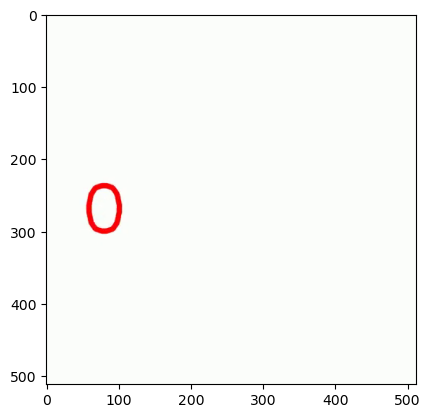

In [4]:
# Initialize clients
s3_client = boto3.client('s3')

response = rekognition.get_text_detection(JobId=job_id)
text_detections = response["TextDetections"]

# Download the video from S3
s3_client.download_file(bucket_name, s3_key, 'downloaded_video.mp4')

# Open the video file with OpenCV
cap = cv2.VideoCapture('downloaded_video.mp4')

# Process each detection
for detection in text_detections:
    print(detection["TextDetection"]["Type"])
    if(detection["TextDetection"]["Type"] == "WORD"):
        detected_text = detection["TextDetection"]['DetectedText']
        confidence = detection["TextDetection"]['Confidence']
        timestamp = detection['Timestamp']

        # Calculate the frame number from the timestamp
        frame_number = int((timestamp / 1000) * cap.get(cv2.CAP_PROP_FPS))
        print("time in sec: ", int(timestamp/1000))
        print("Frame Number: ", frame_number)

        # Set the video frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Read the frame
        ret, frame = cap.read()
        if not ret:
            continue

        # Convert the frame to a PIL image
        frame_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        print(">>>>>>> Detected Text: ", detected_text)


        # Display the frame
        plt.imshow(frame_image)
        plt.show()